In [0]:
import os ; os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/Recurrent Neural Network')

In [0]:
import numpy as np
import theano
import theano.tensor as T   
import matplotlib.pyplot as plt
from utils import init_weight, all_parity_pairs
from sklearn.utils import shuffle

In [0]:
class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W = init_weight(M1, M2)
        b = np.zeros(M2)
        self.W = theano.shared(W, 'W_%s' %self.id)
        self.b =  theano.shared(b, 'b_%s' %self.id)
        self.params = [self.W, self.b]

    def forward(self, X):
        return T.nnet.relu(X.dot(self.W) + self.b)


class ANN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, learning_rate=1e-2, mu = 0.99, reg = 1e-12, epochs = 400, batch_sz = 20, print_period = 1, show_fig= False):
        Y = Y.astype(np.int32)

        #initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W = init_weight(M1, K)
        b = np.zeros(K)
        self.W = theano.shared(W, 'W_logreg')
        self.b = theano.shared(b, 'b_logreg')

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # for momentum
        dparams = [theano.shared(np.zeros(p.get_value().shape)) for p in self.params]

        # for rmsprop 
        cache = [theano.shared(np.zeros(p.get_value().shape)) for p in self.params]

        # set-up theano functions and variables
        thX = T.matrix('X')
        thY = T.ivector('Y')
        pY = self.forward(thX)

        rcost = reg*T.sum([(p*p).sum() for p in self.params])
        cost = -T.mean(T.log(pY[T.arange(thY.shape[0]), thY])) + rcost
        prediction = self.predict(thX)
        grads = T.grad(cost, self.params)

        #momentum only 
        updates = [(p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)] + \
        [(dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)]

        train_op = theano.function(inputs=[thX, thY], outputs=[cost, prediction], updates=updates,)
        n_batches = N // batch_sz
        costs = []
        for i in range(epochs):
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                c, p = train_op(Xbatch, Ybatch)
                
                if j % print_period == 0:
                     costs.append(c)
                     e = np.mean(Ybatch != p)
                     print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return T.nnet.softmax(Z.dot(self.W) + self.b)

    def predict(self, X):
        pY = self.forward(X)
        return T.argmax(pY, axis=1)

def wide():
    X, Y = all_parity_pairs(12)
    model = ANN([1024]*2)
    model.fit(X, Y, learning_rate=1e-3, print_period=10, epochs=100, show_fig=True)

def deep():
    # Challenge - find a deeper, slimmer network to solve the problem
    X, Y = all_parity_pairs(12)
    model = ANN([1024]*2)
    model.fit(X, Y, learning_rate=1e-3, print_period=10, epochs=100, show_fig=True)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


i: 0 j: 0 nb: 205 cost: 0.6909520503600816 error rate: 0.35
i: 0 j: 10 nb: 205 cost: 0.6913236813589443 error rate: 0.35
i: 0 j: 20 nb: 205 cost: 0.6945726660858813 error rate: 0.5
i: 0 j: 30 nb: 205 cost: 0.7037879460691215 error rate: 0.55
i: 0 j: 40 nb: 205 cost: 0.6989137807914299 error rate: 0.55
i: 0 j: 50 nb: 205 cost: 0.6921535306814834 error rate: 0.45
i: 0 j: 60 nb: 205 cost: 0.6921885408222369 error rate: 0.5
i: 0 j: 70 nb: 205 cost: 0.6967282704735523 error rate: 0.6
i: 0 j: 80 nb: 205 cost: 0.694004503319741 error rate: 0.6
i: 0 j: 90 nb: 205 cost: 0.6990151733995089 error rate: 0.65
i: 0 j: 100 nb: 205 cost: 0.6909582357389449 error rate: 0.4
i: 0 j: 110 nb: 205 cost: 0.6933903007262018 error rate: 0.45
i: 0 j: 120 nb: 205 cost: 0.6802075862307911 error rate: 0.3
i: 0 j: 130 nb: 205 cost: 0.7053124532874673 error rate: 0.65
i: 0 j: 140 nb: 205 cost: 0.6940866827244684 error rate: 0.45
i: 0 j: 150 nb: 205 cost: 0.7159507693689043 error rate: 0.6
i: 0 j: 160 nb: 205 cost: 0

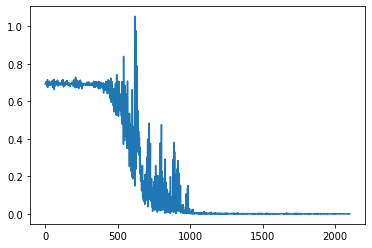

In [4]:
if __name__ == '__main__':
    wide()

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


i: 0 j: 0 nb: 205 cost: 0.6941073095022442 error rate: 0.5
i: 0 j: 10 nb: 205 cost: 0.6819049162561772 error rate: 0.3
i: 0 j: 20 nb: 205 cost: 0.7062724957332795 error rate: 0.6
i: 0 j: 30 nb: 205 cost: 0.6992415999476144 error rate: 0.55
i: 0 j: 40 nb: 205 cost: 0.6949088912920082 error rate: 0.5
i: 0 j: 50 nb: 205 cost: 0.6939674186275286 error rate: 0.5
i: 0 j: 60 nb: 205 cost: 0.6975424178144537 error rate: 0.5
i: 0 j: 70 nb: 205 cost: 0.6916318326719016 error rate: 0.5
i: 0 j: 80 nb: 205 cost: 0.6944008548308346 error rate: 0.5
i: 0 j: 90 nb: 205 cost: 0.6954853153069152 error rate: 0.55
i: 0 j: 100 nb: 205 cost: 0.6905844519732315 error rate: 0.5
i: 0 j: 110 nb: 205 cost: 0.6954216336836265 error rate: 0.55
i: 0 j: 120 nb: 205 cost: 0.7010385401782138 error rate: 0.8
i: 0 j: 130 nb: 205 cost: 0.7089806599291841 error rate: 0.8
i: 0 j: 140 nb: 205 cost: 0.7006073235972101 error rate: 0.65
i: 0 j: 150 nb: 205 cost: 0.695268299830649 error rate: 0.45
i: 0 j: 160 nb: 205 cost: 0.700

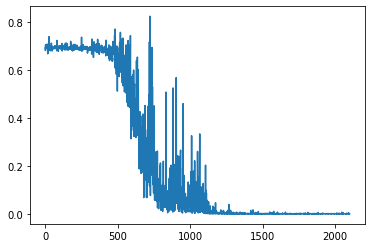

In [6]:
if __name__ == '__main__':
    deep()